# Cell 1: Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from itertools import tee
import pickle as pkl

from matplotlib import ticker
import os

from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow
from structure_factor.hyperuniformity import bin_data
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf


In [2]:
def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]
    return x, Y0 * x**scaling_exp / x[0]**scaling_exp

# Cell 2: Load & reshape data into 3D arrays

In [10]:
data_dirs = 'C:\\Users\\Simon Andersen\\OneDrive - University of Copenhagen\\PhD\\Active Nematic Defect Transition\\Tianxiang data\\data_new'
save_path = os.path.join(data_dirs, 'figs')
if not os.path.exists(save_path):
    os.makedirs(save_path)
defect_path = os.path.join(data_dirs, 'defect_positions.pkl')
params_path = os.path.join(data_dirs, 'parameters.pkl')
# load
with open(defect_path, 'rb') as f:
    defect_list = pkl.load(f)
with open(params_path, 'rb') as f:
    params_dict = pkl.load(f)

sfac = np.load(os.path.join(data_dirs, 'sfac.npy'))
#pcf = np.load(os.path.join(data_dirs, 'pcf.npy'))
kbins = np.loadtxt(os.path.join(data_dirs, 'kbins.txt'))
Ndefects = np.loadtxt(os.path.join(data_dirs, 'Ndefects.txt'))
av_counts = np.load(os.path.join(data_dirs, 'av_counts_periodic_rm0.125.npy'))
window_sizes = np.loadtxt(os.path.join(data_dirs, 'window_sizes.txt'))

pcf_arr = np.load(os.path.join(data_dirs, 'pcf_arr.npy'))
rad_arr = np.load(os.path.join(data_dirs, 'rad_arr.npy'))

In [30]:
fidx_bounds=[100, 149]
Nframes = fidx_bounds[1] - fidx_bounds[0]
Ndist_ind = 10

av_counts_full = np.zeros((len(window_sizes), 2))
av_var_full = np.zeros((len(window_sizes), 2))
sfac_tav_full = np.zeros((len(kbins), 2))
pcf_tav_from100 = np.zeros((len(rad_arr), 2))

av_counts_full[:,0] = np.nanmean(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis=0)
av_counts_full[:,1] = np.nanstd(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], ddof=1, axis = 0) /  np.sqrt(Nframes / Ndist_ind)
av_var_full[:,0] = np.nanvar(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], ddof=1, axis = 0)
av_var_full[:,1] = (np.nanstd(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], ddof=1, axis = 0) /  np.sqrt(Nframes / Ndist_ind)) ** 2

sfac_tav_full[:, 0] = np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0)
sfac_tav_full[:, 1] = np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,1], axis = 0) / np.sqrt(Nframes / Ndist_ind)

pcf_tav_from100[:, 0] = np.nanmean(pcf_arr, axis = 0)
pcf_tav_from100[:, 1] = np.nanstd(pcf_arr, ddof=1, axis = 0) / np.sqrt(Nframes / Ndist_ind)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8448\449535984.py:18: RuntimeWarning: Mean of empty slice
  pcf_tav_from100[:, 0] = np.nanmean(pcf_arr, axis = 0)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### add fit params for gnf og sfac

In [40]:

#####
# NB: add fit params for gnf og sfac også
#####

fidx_bounds=[100, 149]
save_path_results = os.path.join(data_dirs,'results_tianxiang.npz')

np.savez(save_path_results, kbins=kbins, sfac=sfac, av_sfac_from100 = sfac_tav_full, \
         Ndefects=Ndefects, window_sizes=window_sizes, \
         counts = av_counts, av_counts_from100 = av_counts_full, av_variance_from100 = av_var_full, \
         pcf_rad_arr = rad_arr, pcf_arr = pcf_arr, av_pcf_from100 = pcf_tav_from100)

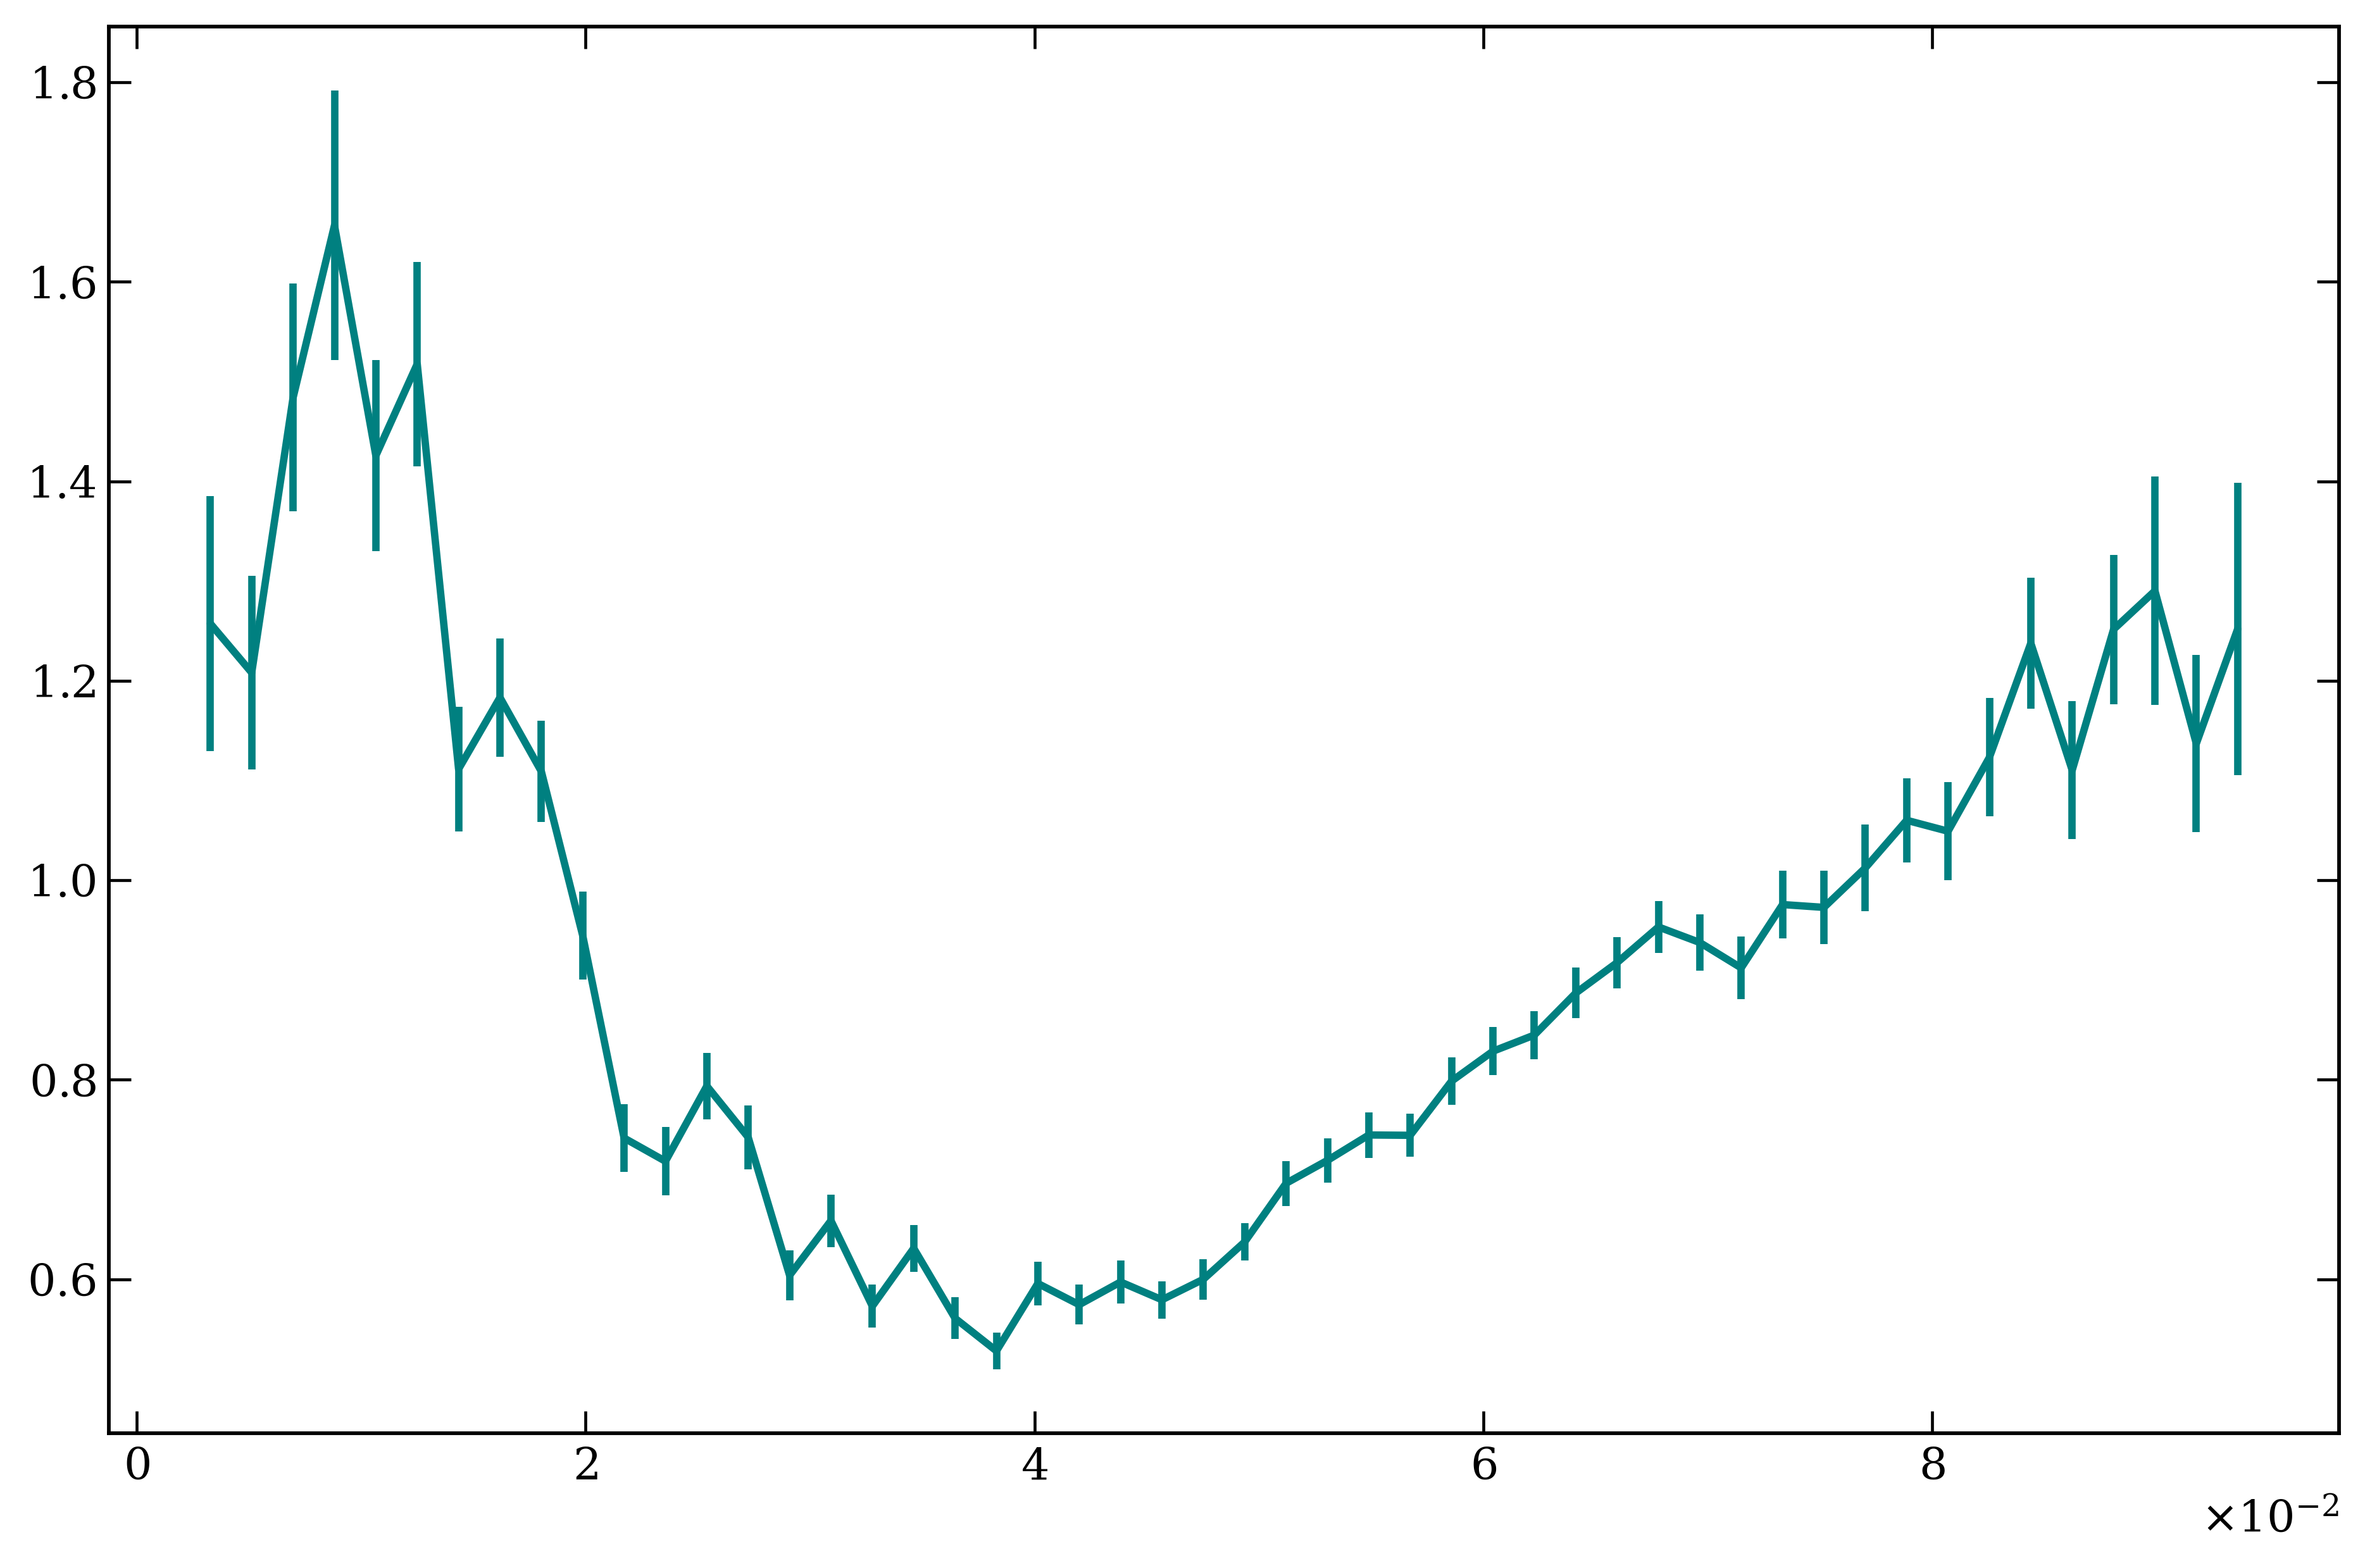

In [39]:
plt.errorbar(kbins, sfac_tav_full[:,0], sfac_tav_full[:,1])
plt.tight_layout()

#plt.xscale('log')
#plt.yscale('log')

plt.savefig(os.path.join(save_path, 'sfac.png'), dpi=420, )

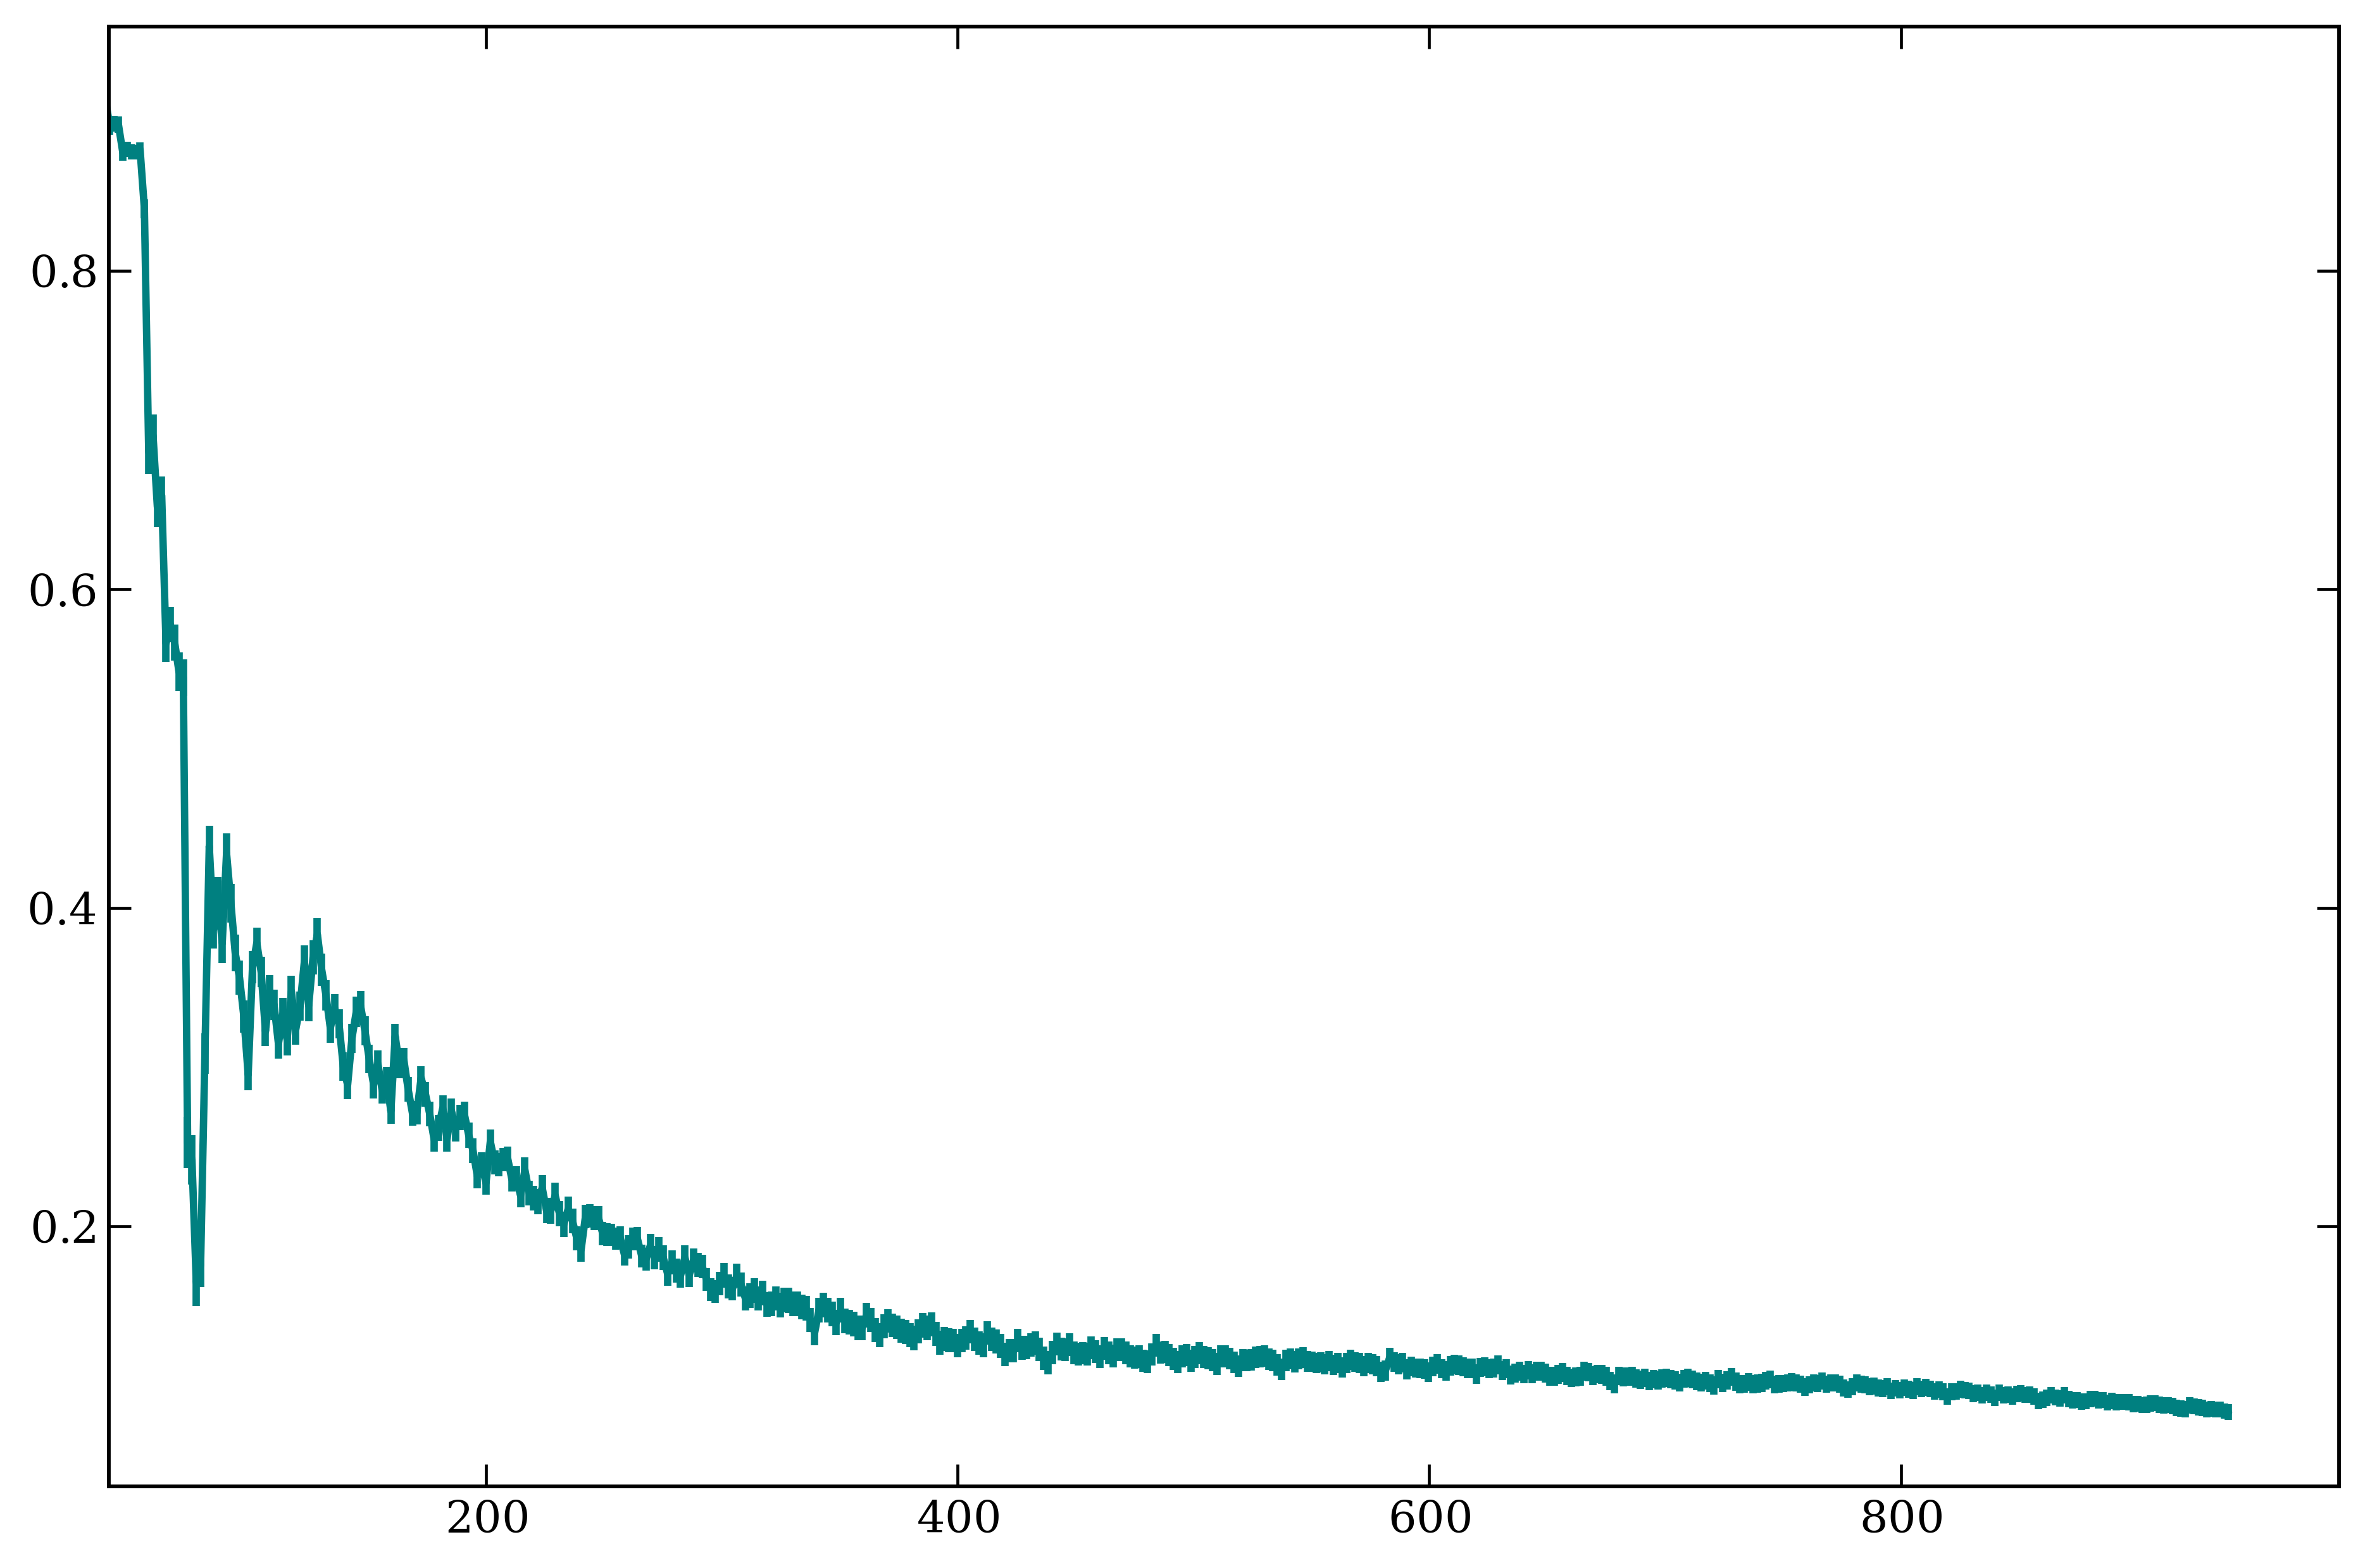

In [38]:
plt.errorbar(rad_arr, np.abs((pcf_tav_from100[:,0] - 1)/pcf_tav_from100[1,0]), pcf_tav_from100[:,1])
plt.tight_layout()

plt.xlim(xmin=40)
plt.savefig(os.path.join(save_path, 'pcf.png'), dpi=420, )


In [95]:
xdb = [1,1]
ydb = [1,1]

for i, def_dict in enumerate(defect_list):
    def_arr = get_defect_arr_from_frame(def_dict)
    xbounds = [def_arr[:,0].min(), def_arr[:,0].max()]
    ybounds = [def_arr[:,1].min(), def_arr[:,1].max()]
    if i == 0:
        xdb = xbounds
        ydb = ybounds
    else:
        xdb[0] = min(xdb[0], xbounds[0])
        xdb[1] = max(xdb[1], xbounds[1])
        ydb[0] = min(ydb[0], ybounds[0])
        ydb[1] = max(ydb[1], ybounds[1])
xdb, ydb, 94* 40

([0.0, 93.9], [0.0, 93.83333333333333], 3760)

In [ ]:
ff_idx=100
pcf_norm = pcf_arr[ff_idx:, 1]
plt.plot(rad_arr, np.nanmean(pcf_arr[ff_idx:,:] / pcf_norm[:,None], axis=0))
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
lattice_spacing = 40
param_key = 'frame101-150'
LX_bounds, LY_bounds = params_dict[param_key]['LX_bounds'], params_dict[param_key]['LY_bounds']
LX_bounds, LY_bounds = [28,28+40*94], params_dict[param_key]['LY_bounds']
rmax = int((LX_bounds[-1] - LX_bounds[0])/4 - 1) 

nknots = int(rmax / (lattice_spacing / 2))
method = 'fv'
spar = 1.2
smoothing_kwargs = dict(method="b", spar=spar, nknots=nknots)
kest_kwargs = {'rmax': rmax, 'correction': 'good', 'nlarge': 3000, 'var.approx': False}

box_window = BoxWindow(bounds=[LX_bounds, LY_bounds])  

Text(0, 0.5, 'Defect count variation ($\\sigma^2_N(R)$)')

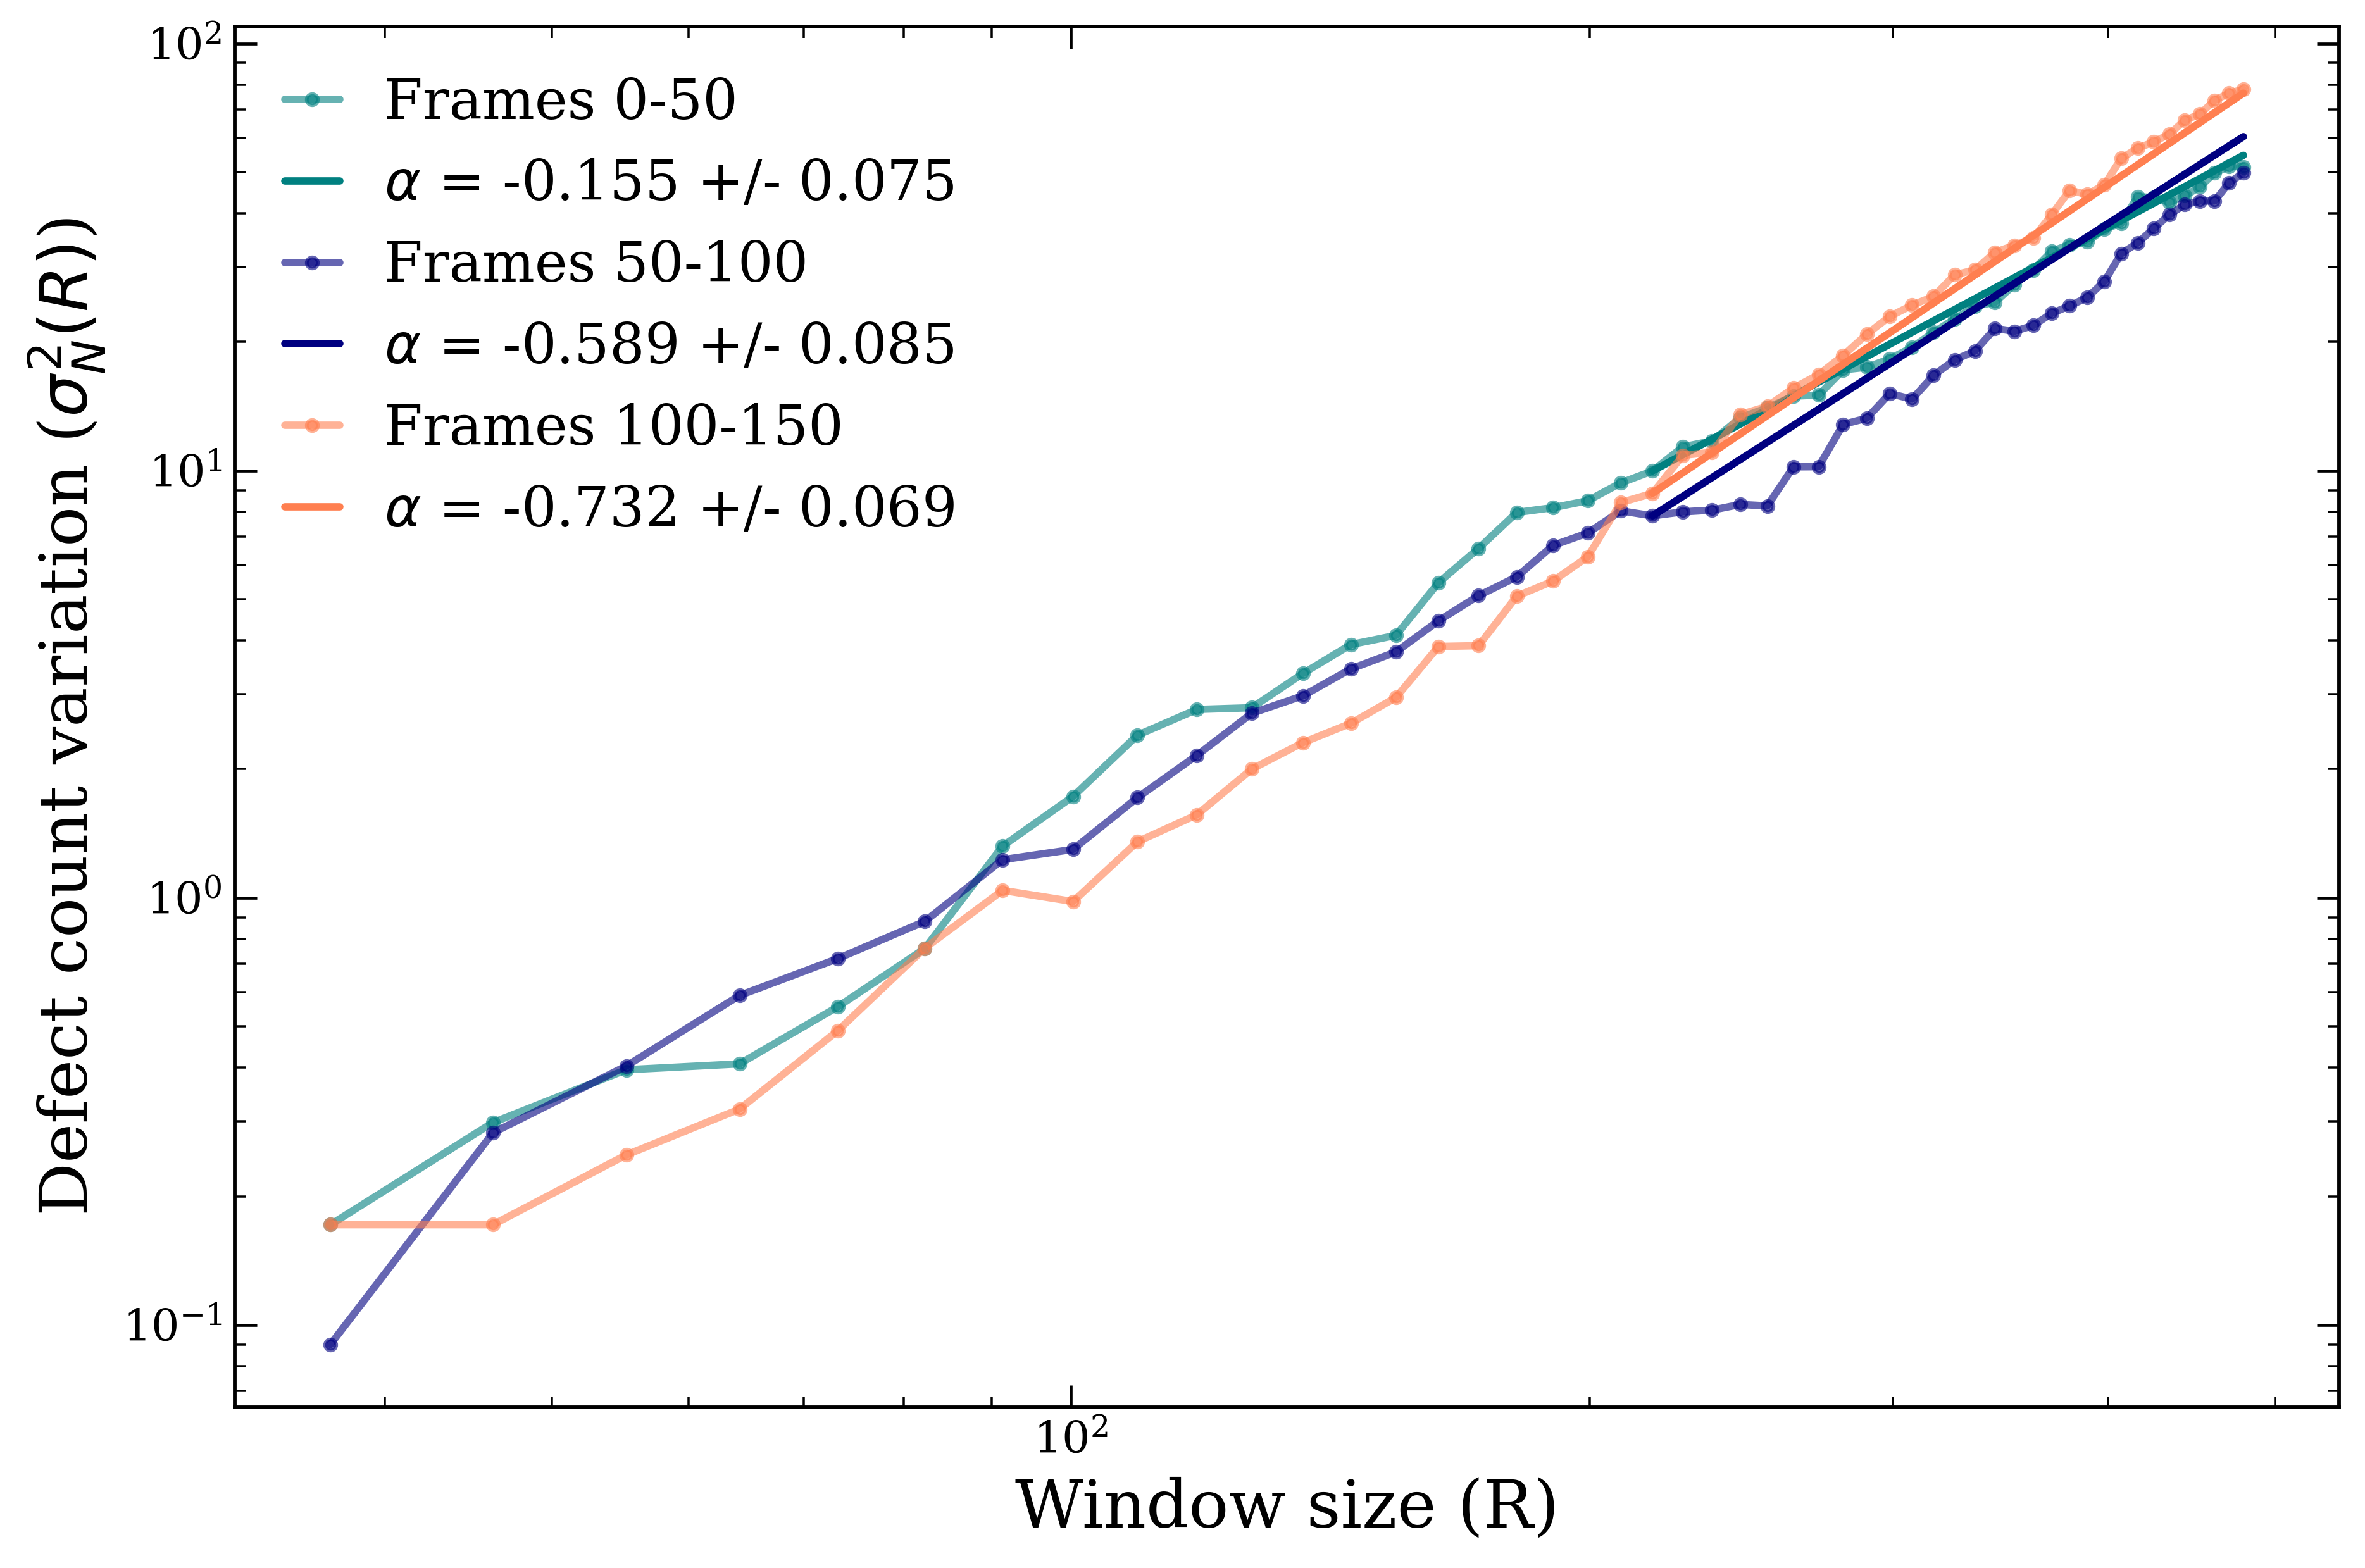

In [184]:
Ndist_ind = 10
Nframes = len(defect_list)
window_idx_bounds=[20,50]

def fit_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
param_guess = np.array([-1, .4])
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
Nparams = len(param_guess)

fit_params = np.zeros([3, 4]) * np.nan
stat_arr = np.zeros([3,4]) * np.nan
alpha_list = np.zeros([3,4]) * np.nan

for i in range(3):

    fidx_bounds=[i * 50, i * 50 + 50]

    av_counts_av = np.nanmean(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis=0)
    av_var = np.nanvar(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0)
    av_var_std = np.nanstd(av_counts[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0) \
                /  np.sqrt((fidx_bounds[-1] - fidx_bounds[0])/Ndist_ind)

    

    windows = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]

    av_counts_av = av_counts_av[window_idx_bounds[0]:window_idx_bounds[1]]
    count_var_av = av_var[window_idx_bounds[0]:window_idx_bounds[1],]
    count_var_std = av_var_std[window_idx_bounds[0]:window_idx_bounds[1],]

    zero_mask = (count_var_av > 0) & (count_var_std > 0)

    if len(count_var_av[zero_mask]) < 5:
        print('Not enough data points')
        continue

    try:
        x = np.log(windows[zero_mask])
        y = np.log(count_var_av[zero_mask])
        yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
    except:
        print('Not enough data points2')
        continue
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)


    #stat_arr[i, :] = get_statistics_from_fit(fit, len(x), subtract_1dof_for_binning = False)
    fit_params[i, :Nparams] = fit.values[:]
    fit_params[i, Nparams:] = fit.errors[:]

  #  X, Y = produce_scaling(window_sizes, 2-fit.values[0], 6 if i==1 else 10, [20,50])
    #plt.plot(X,Y, label=rf'$\alpha$ = {fit.values[0]:.3f} +/- {fit.errors[0]:.3f}', color=f'C{i}')

    #X, Y = produce_scaling(av_counts_av, 0.5, 3, [20,50])
    plt.plot(window_sizes[:window_idx_bounds[-1]], av_var[:window_idx_bounds[-1]], '.-', color=f'C{i}',
             alpha=.6, label = f'Frames {i*50}-{i*50+50}')
    
    X, Y = produce_scaling(window_sizes, 2-fit.values[0], count_var_av[0], window_idx_bounds)
    plt.plot(X,Y, label=rf'$\alpha$ = {fit.values[0]:.3f} +/- {fit.errors[0]:.3f}', color=f'C{i}')

    #plt.errorbar(av_counts_av[:ridx_max], np.sqrt(av_var[:ridx_max]),
    #            np.sqrt(av_var_std[:ridx_max]), fmt= '.', color=f'C{i}',
    #            alpha=.6, zorder=-10,
    #            label = f'{i}')
    
#X, Y = produce_scaling(window_sizes, 2, 10, [20,50])
#plt.plot(X,Y, label='0.7')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(rf'Window size (R)')
plt.ylabel(rf'Defect count variation ($\sigma^2_N(R)$)')

#plt.savefig(os.path.join(save_path, 'count_var.png'), dpi=420, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
Nframes = len(defect_list)
Ndefects_av = Ndefects.mean()
ax.plot(np.arange(Nframes), Ndefects, marker='o', markersize=3, alpha=.6, lw=1,
        )

ax.hlines(Ndefects_av, 0, 150, ls='-',lw=1, color='k', label = 'Mean')
ax.set_xlabel('Frame')
ax.set_ylabel('Ndefects')
ax.legend()
fig.savefig(os.path.join(save_path, 'Ndefects.png'), dpi=420, bbox_inches='tight')

In [23]:
data_names = ['frame1-50.csv', 'frame51-100.csv', 'frame101-150.csv']
data_dict = {}
for i, file in enumerate(data_names):
    key_name = file.split('.')[0]
    data_dict[key_name] = pd.read_csv(os.path.join(data_dirs, file),) 

key_list = list(data_dict.keys())
df = data_dict[key_list[-1]]  # Change index to select different data file


df['X']  *= 2
df['Y']  *= 2
df['DX'] *= 2
df['DY'] *= 2

# sorted unique coords & times
x_coords = np.sort(df['X'].unique())
y_coords = np.sort(df['Y'].unique())
times    = np.sort(df['Slice'].unique())

nx, ny, nt = len(x_coords), len(y_coords), len(times)

# build index maps
ix_map = {x:i for i, x in enumerate(x_coords)}
iy_map = {y:j for j, y in enumerate(y_coords)}
t_map  = {t:k for k, t in enumerate(times)}

# allocate U,V
U = np.zeros((nx, ny, nt))
V = np.zeros((nx, ny, nt))

# fill
for _, row in df.iterrows():
    i = ix_map[row['X']]
    j = iy_map[row['Y']]
    k = t_map[row['Slice']]
    U[i, j, k] = row['DX']
    V[i, j, k] = row['DY']

# meshgrid for plotting (shape ny×nx)
Xg, Yg = np.meshgrid(x_coords, y_coords)

# Cell 3: Quick director‐field plot for one frame

In [ ]:
from matplotlib.collections import LineCollection

k = t_map[10]

# Recompute the nematic director segments for frame k
U_s, V_s = U[:,:,k], V[:,:,k]
phi = 0.5 * np.arctan2(2*U_s*V_s, U_s**2 - V_s**2)  # angle in [0, π)
L = min(x_coords[1]-x_coords[0], y_coords[1]-y_coords[0]) * 2
Phi = phi.T
dxs =  L * 0.1 * np.cos(Phi)
dys =  L * 0.1 * np.sin(Phi)

segments = [
    [[x0 - dx, y0 - dy], [x0 + dx, y0 + dy]]
    for x0, y0, dx, dy in zip(Xg.ravel(), Yg.ravel(), dxs.ravel(), dys.ravel())
]

lc = LineCollection(segments, colors='black', linewidths=1)

# Plot
mm = 1/25.4

fig, ax = plt.subplots(figsize=(48*mm, 48*mm), dpi=300)
ax.add_collection(lc)

ax.set_xlim(x_coords.min(), x_coords.max())
ax.set_ylim(y_coords.min(), y_coords.max()) 
ax.set_aspect('equal')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.legend(loc='upper right')
plt.show()

# Cell 4: Define topological‐defect detection

In [135]:

from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow
from structure_factor.hyperuniformity import bin_data
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf

def get_structure_factor(top_defect_list, box_window, lattice_space_scaling = 1,
                         kmax = 1, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(top_defect_list)

    # Initialize structure factor
    sf_arr_init = False

    for i, defects in enumerate(top_defect_list):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defects)

        if defect_positions is None:
            continue

        defect_positions *= lattice_space_scaling

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax,)
    
        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if not sf_arr_init:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
            sf_arr_init = True
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    if sf_arr_init:
        return kbins_arr, sf_arr
    else:
        return None, None

def analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)
    Nact = sfac_av.shape[1]

    fit_params_sfac_time_av = np.zeros([Nact, 2 * Nparams]) * np.nan

    for i in range(Nact):
        try:
            x = np.log(kbins)
            y = np.log(sfac_av[:, i, 0])
            yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0] 
        except:
            continue

        fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
        fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit],
                                   param_guess, verbose = False)
                
                fit_vals[j] = fit.values[:] if fit._fmin.is_valid else [np.nan, np.nan]
                fit_err[j] = fit.errors[:] if fit._fmin.is_valid  else [np.nan, np.nan]
            nan_mask = np.isnan(fit_vals[:,0])
            fit_vals_valid = fit_vals[~nan_mask]
            fit_err_valid = fit_err[~nan_mask]

            if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
                continue
            if len(fit_vals) > 1:
                alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
                beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
                alpha_std, beta_std = np.std(fit_vals_valid, axis = 0)
            else:
                alpha_weighted_av, beta_weighted_av = fit.values[:]
                alpha_sem, beta_sem = fit.errors[:]

          #  print("\n",alpha_weighted_av, np.nanmean(fit_vals_valid[:,0]))
           # print(alpha_sem, alpha_std / np.sqrt(fit_vals_valid.shape[0]))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            fit_params_sfac_time_av[i, :Nparams] = alpha_weighted_av, beta_weighted_av
            fit_params_sfac_time_av[i, Nparams:] = alpha_sem, beta_sem
   
    return fit_params_sfac_time_av


In [4]:
Ndist_ind = 10
Ngroupings = 3
sfac_tav_full = np.zeros((sfac.shape[1], Ngroupings, 2))

for i in range(Ngroupings):
    Nsamples = int(sfac.shape[0] / Ngroupings)
    fidx_bounds = [i * Nsamples, i * Nsamples + Nsamples]

    sfac_tav_full[:, i, 0] = np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0)
    sfac_tav_full[:, i, 1] = np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,1], axis = 0) / np.sqrt(Nsamples / Ndist_ind)

fitp = analyze_sfac_time_av(kbins,sfac_tav_full, Npoints_bounds=[8,10])
#fitp
np.save(os.path.join(data_dirs,f'fit_params_Ngroupings{Ngroupings}'), fitp)

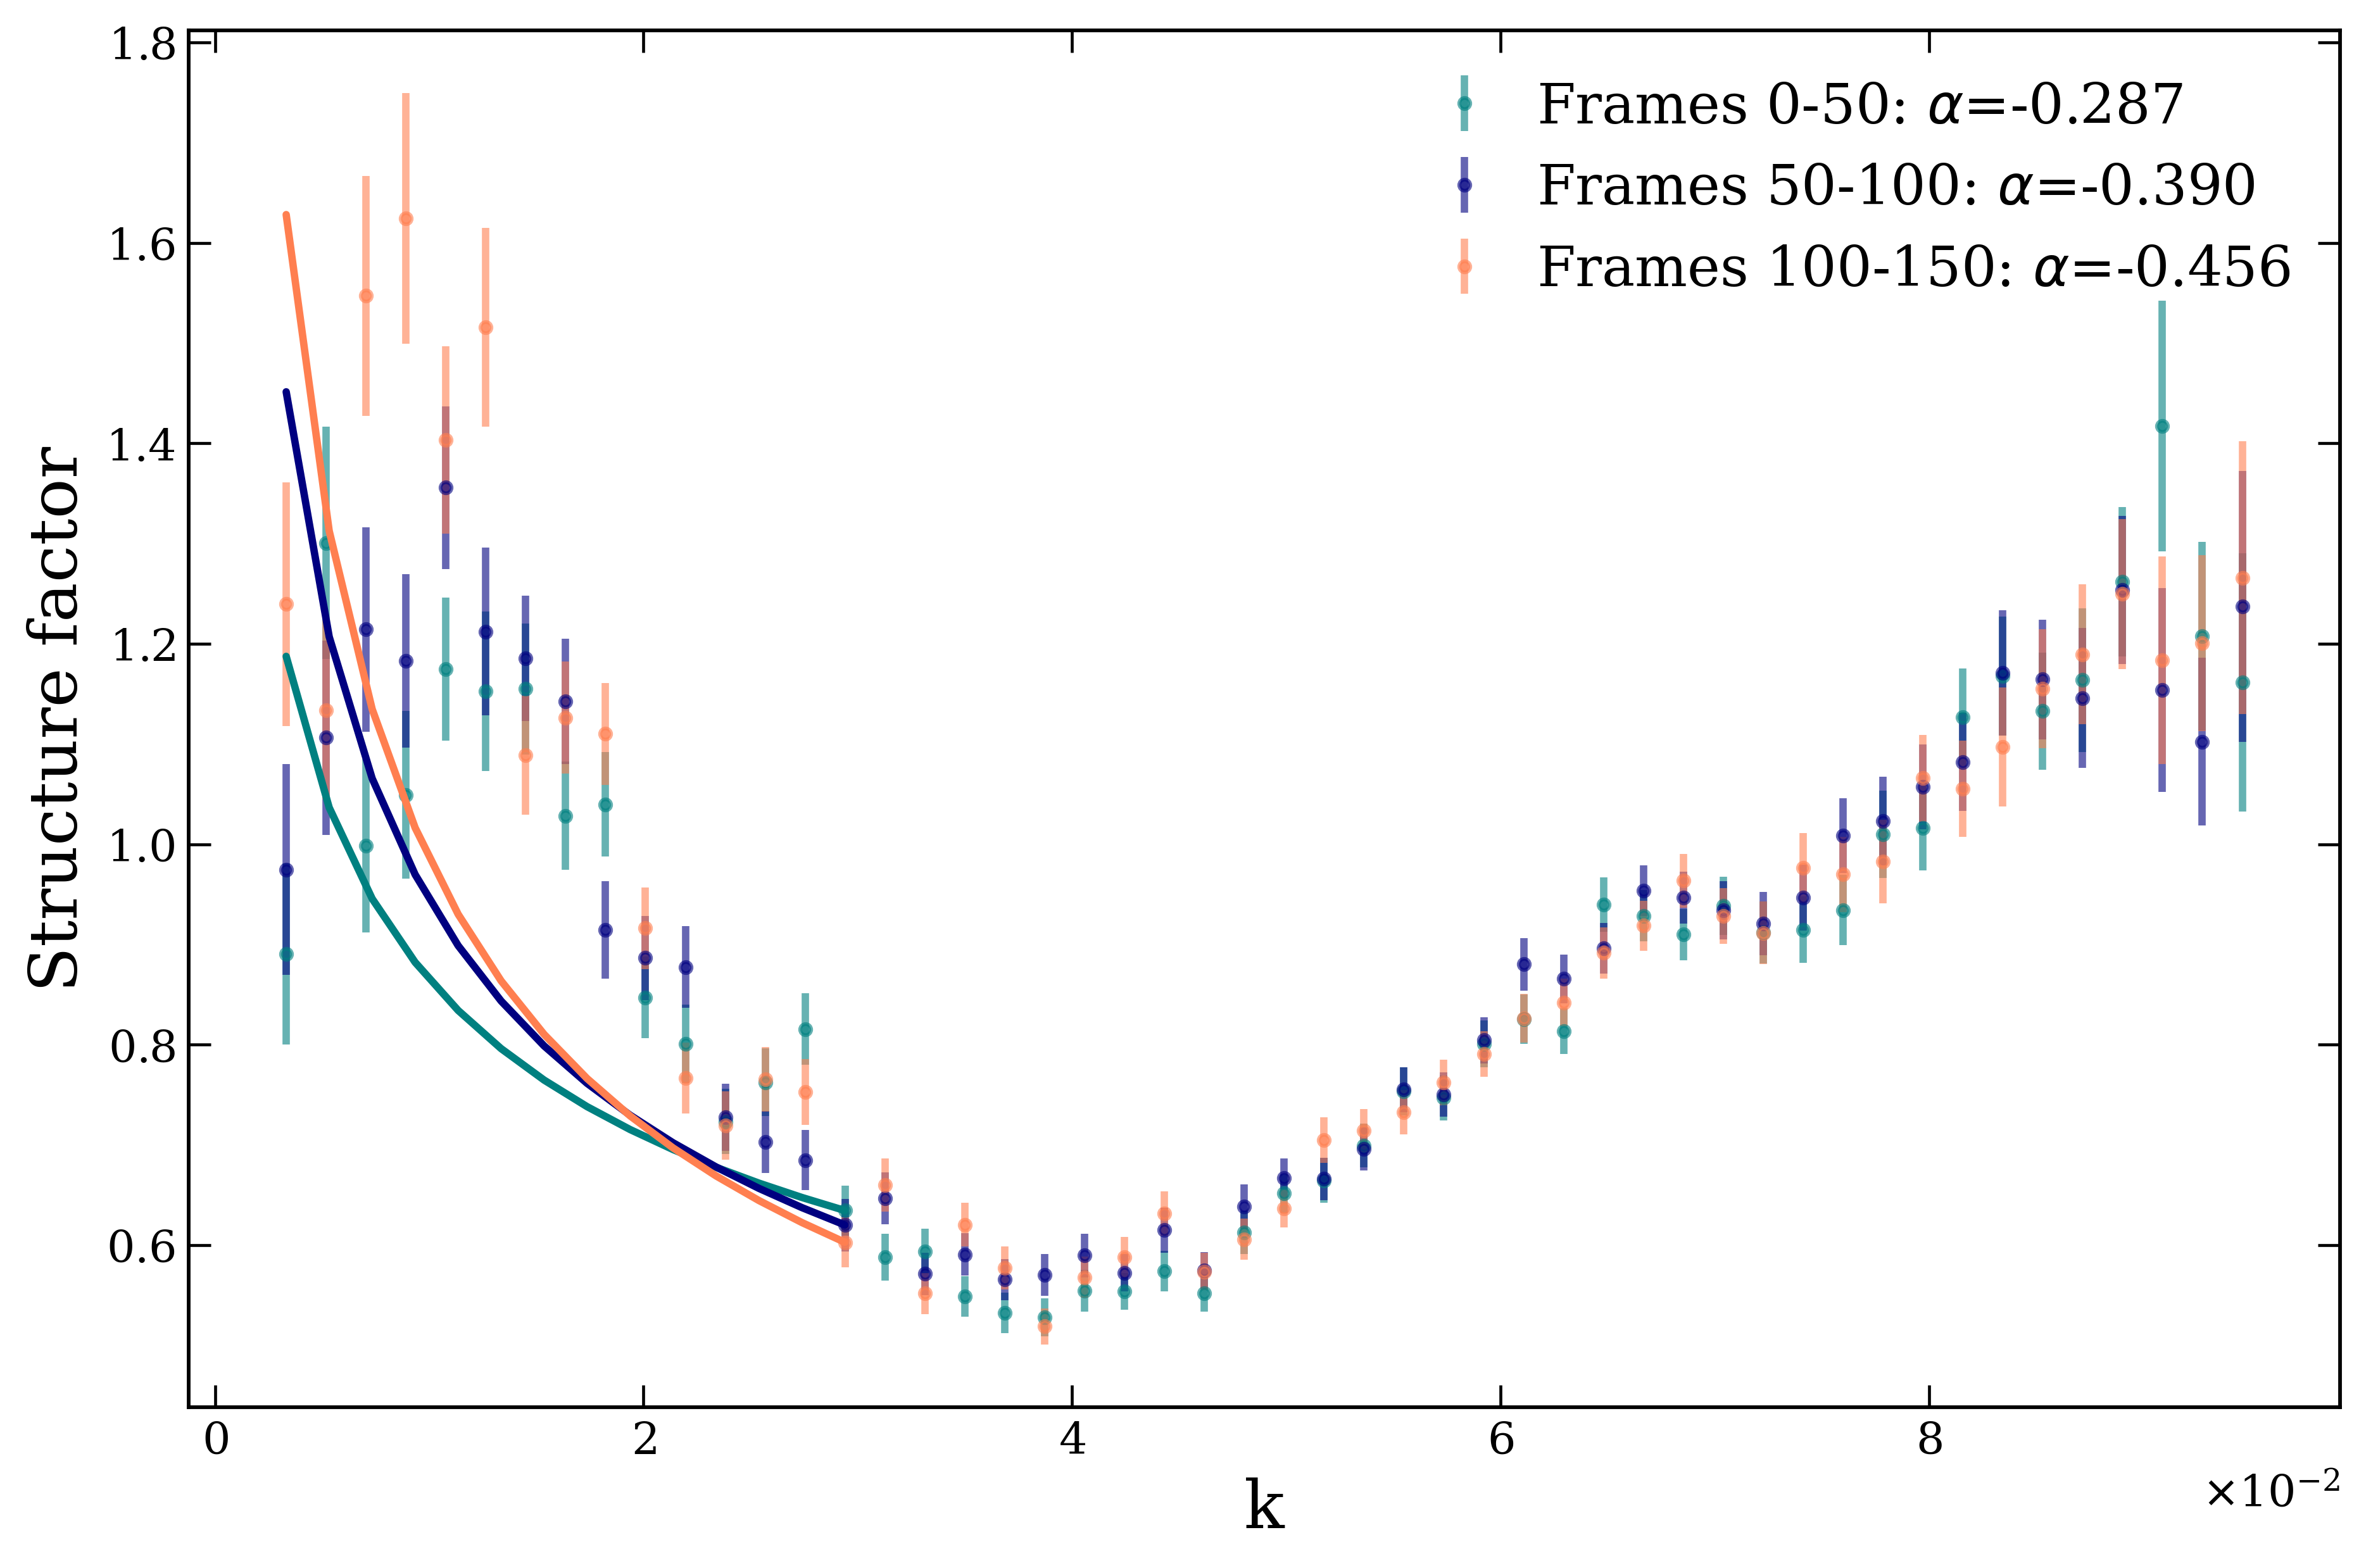

In [29]:
Ndist_ind = 10
Ngroupings = 3
Npoints_bounds=[14,16]
sfac_tav_full = np.zeros((sfac.shape[1], Ngroupings, 2))

for i in range(Ngroupings):
    Nsamples = int(sfac.shape[0] / Ngroupings)
    fidx_bounds = [i * Nsamples, i * Nsamples + Nsamples]

    sfac_tav_full[:, i, 0] = np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,0], axis = 0)
    sfac_tav_full[:, i, 1] = np.nanmean(sfac[fidx_bounds[0]:fidx_bounds[1],:,1], axis = 0) / np.sqrt(Nsamples / Ndist_ind)

fitp = analyze_sfac_time_av(kbins,sfac_tav_full, Npoints_bounds=Npoints_bounds)
#fitp
np.save(os.path.join(data_dirs,f'fit_params_Ngroupings{Ngroupings}'), fitp)

for i in range(3):
    
    fidx_bounds = [i * 50, i * 50 + 50]
    plt.errorbar(kbins, sfac_tav_full[:, i, 0], 
                 sfac_tav_full[:, i,1], color = f'C{i}',
                 label=rf'Frames {fidx_bounds[0]}-{fidx_bounds[1]}: $\alpha$={fitp[i,0]:.3f}', 
                 alpha=.6, zorder=-10, fmt='.',)
    
    k_begin_lines_idx = Npoints_bounds[0]
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], k_begin_lines_idx)
    plt.plot(x, sfac_tav_full[k_begin_lines_idx,i,0] * x**fitp[i,0]/ x[-1]**fitp[i,0],
             color = f'C{i}', lw=2, zorder=10)# label=rf'$k$^{fitp[i,0]}')
#plt.errorbar(kbins, np.nanmean(sfac[:50,:,0], axis=0), 
#             np.nanmean(sfac[:,:,1], axis=0)/np.sqrt(10), label='Av. all frames')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel('k')
plt.ylabel('Structure factor')
plt.savefig(os.path.join(save_path, f'sfac_all_frames_grouped_Np{Npoints_bounds[0]}.png'), dpi=420, bbox_inches='tight')

In [ ]:
from structure_factor.spatial_windows import BoxWindow
ffidx=100
Nx,Ny = 94, 94
lattice_spacing=40
LX_bounds0, LY_bounds0 = [0, Nx], [0, Ny]

LX_bounds1, LY_bounds1 = params_dict['frame101-150']['LX_bounds'], params_dict['frame101-150']['LX_bounds']   #[x_coords.min(), x_coords.max()], [x_coords.min(), x_coords.max()]
#LX_bounds2 = [0,params_dict['frame101-150']['LX_bounds'][1]] #params_dict['frame101-150']['LX_bounds'], params_dict['frame101-150']['LX_bounds']   #[x_coords.min(), x_coords.max()], [x_coords.min(), x_coords.max()]
#LY_bounds2 = [0,params_dict['frame101-150']['LX_bounds'][1]]

LXB = Nx * lattice_spacing / 50

LX_bounds1, LY_bounds1 = [[LXB, Nx * lattice_spacing - LXB],[LXB, Nx * lattice_spacing - LXB]]
LX_bounds2, LY_bounds2 = [[0, Nx * lattice_spacing],[0, Nx * lattice_spacing]]

# Define sfac parameters
box_window = BoxWindow(bounds=[LX_bounds, LY_bounds])  
kmax0 = 256 / Nx
kmax1 = (256) / (LX_bounds1[1] - LX_bounds1[0])
kmax2 = (256) / (LX_bounds2[1] - LX_bounds2[0])
#kmax2 = (2 * np.pi) / (lattice_spacing)
nbins1 = 50
nbins2 = 50

#kbins0, sfac0 = get_structure_factor(defect_list[ffidx:], BoxWindow(bounds=[LX_bounds0, LY_bounds0]) , lattice_space_scaling=1, 
#                                            kmax = kmax0, nbins = 50,)
#kbins1, sfac1 = get_structure_factor(defect_list[ffidx:], BoxWindow(bounds=[LX_bounds1, LY_bounds1]) , lattice_space_scaling=40, 
#                                            kmax = kmax1, nbins = nbins1,)
kbins2, sfac2 = get_structure_factor(defect_list[ffidx:],BoxWindow(bounds=[LX_bounds2, LY_bounds2]), lattice_space_scaling=40, 
                                            kmax = kmax2, nbins = 50,)

In [154]:
LXB = Nx * lattice_spacing / 20

LX_bounds1, LY_bounds1 = [[LXB, Nx * lattice_spacing - LXB],[LXB, Nx * lattice_spacing - LXB]]
kmin = (2*np.pi)/((LX_bounds1[1] - LX_bounds1[0])/2)
kmin

0.0037134664936049563

In [ ]:
Ndist_ind = 10
Ngroupings = 1
Npoints_bounds=[12,16]
sfac2_tav = np.zeros((sfac2.shape[1], 1, 2))


Nsamples = int(sfac2.shape[0] / Ngroupings)
fidx_bounds = [i * Nsamples, i * Nsamples + Nsamples]
sfac2_tav[:,0,0] = np.nanmean(sfac2[:,:,0], axis = 0)
sfac2_tav[:,0,1] = np.nanmean(sfac2[:,:,1], axis = 0) / np.sqrt(Nsamples / Ndist_ind)

for i in range(4,25):
    Npoints_bounds=[i,i+1]

    fitp = analyze_sfac_time_av(kbins2[:],sfac2_tav[:,:,:], Npoints_bounds=Npoints_bounds)
    print(i, f': for alpha = {fitp[0][0]:.3f} +/- {fitp[0][2]:.3f}')
#fitp
#np.save(os.path.join(data_dirs,f'fit_params_ff100.npy'), fitp)
fitp

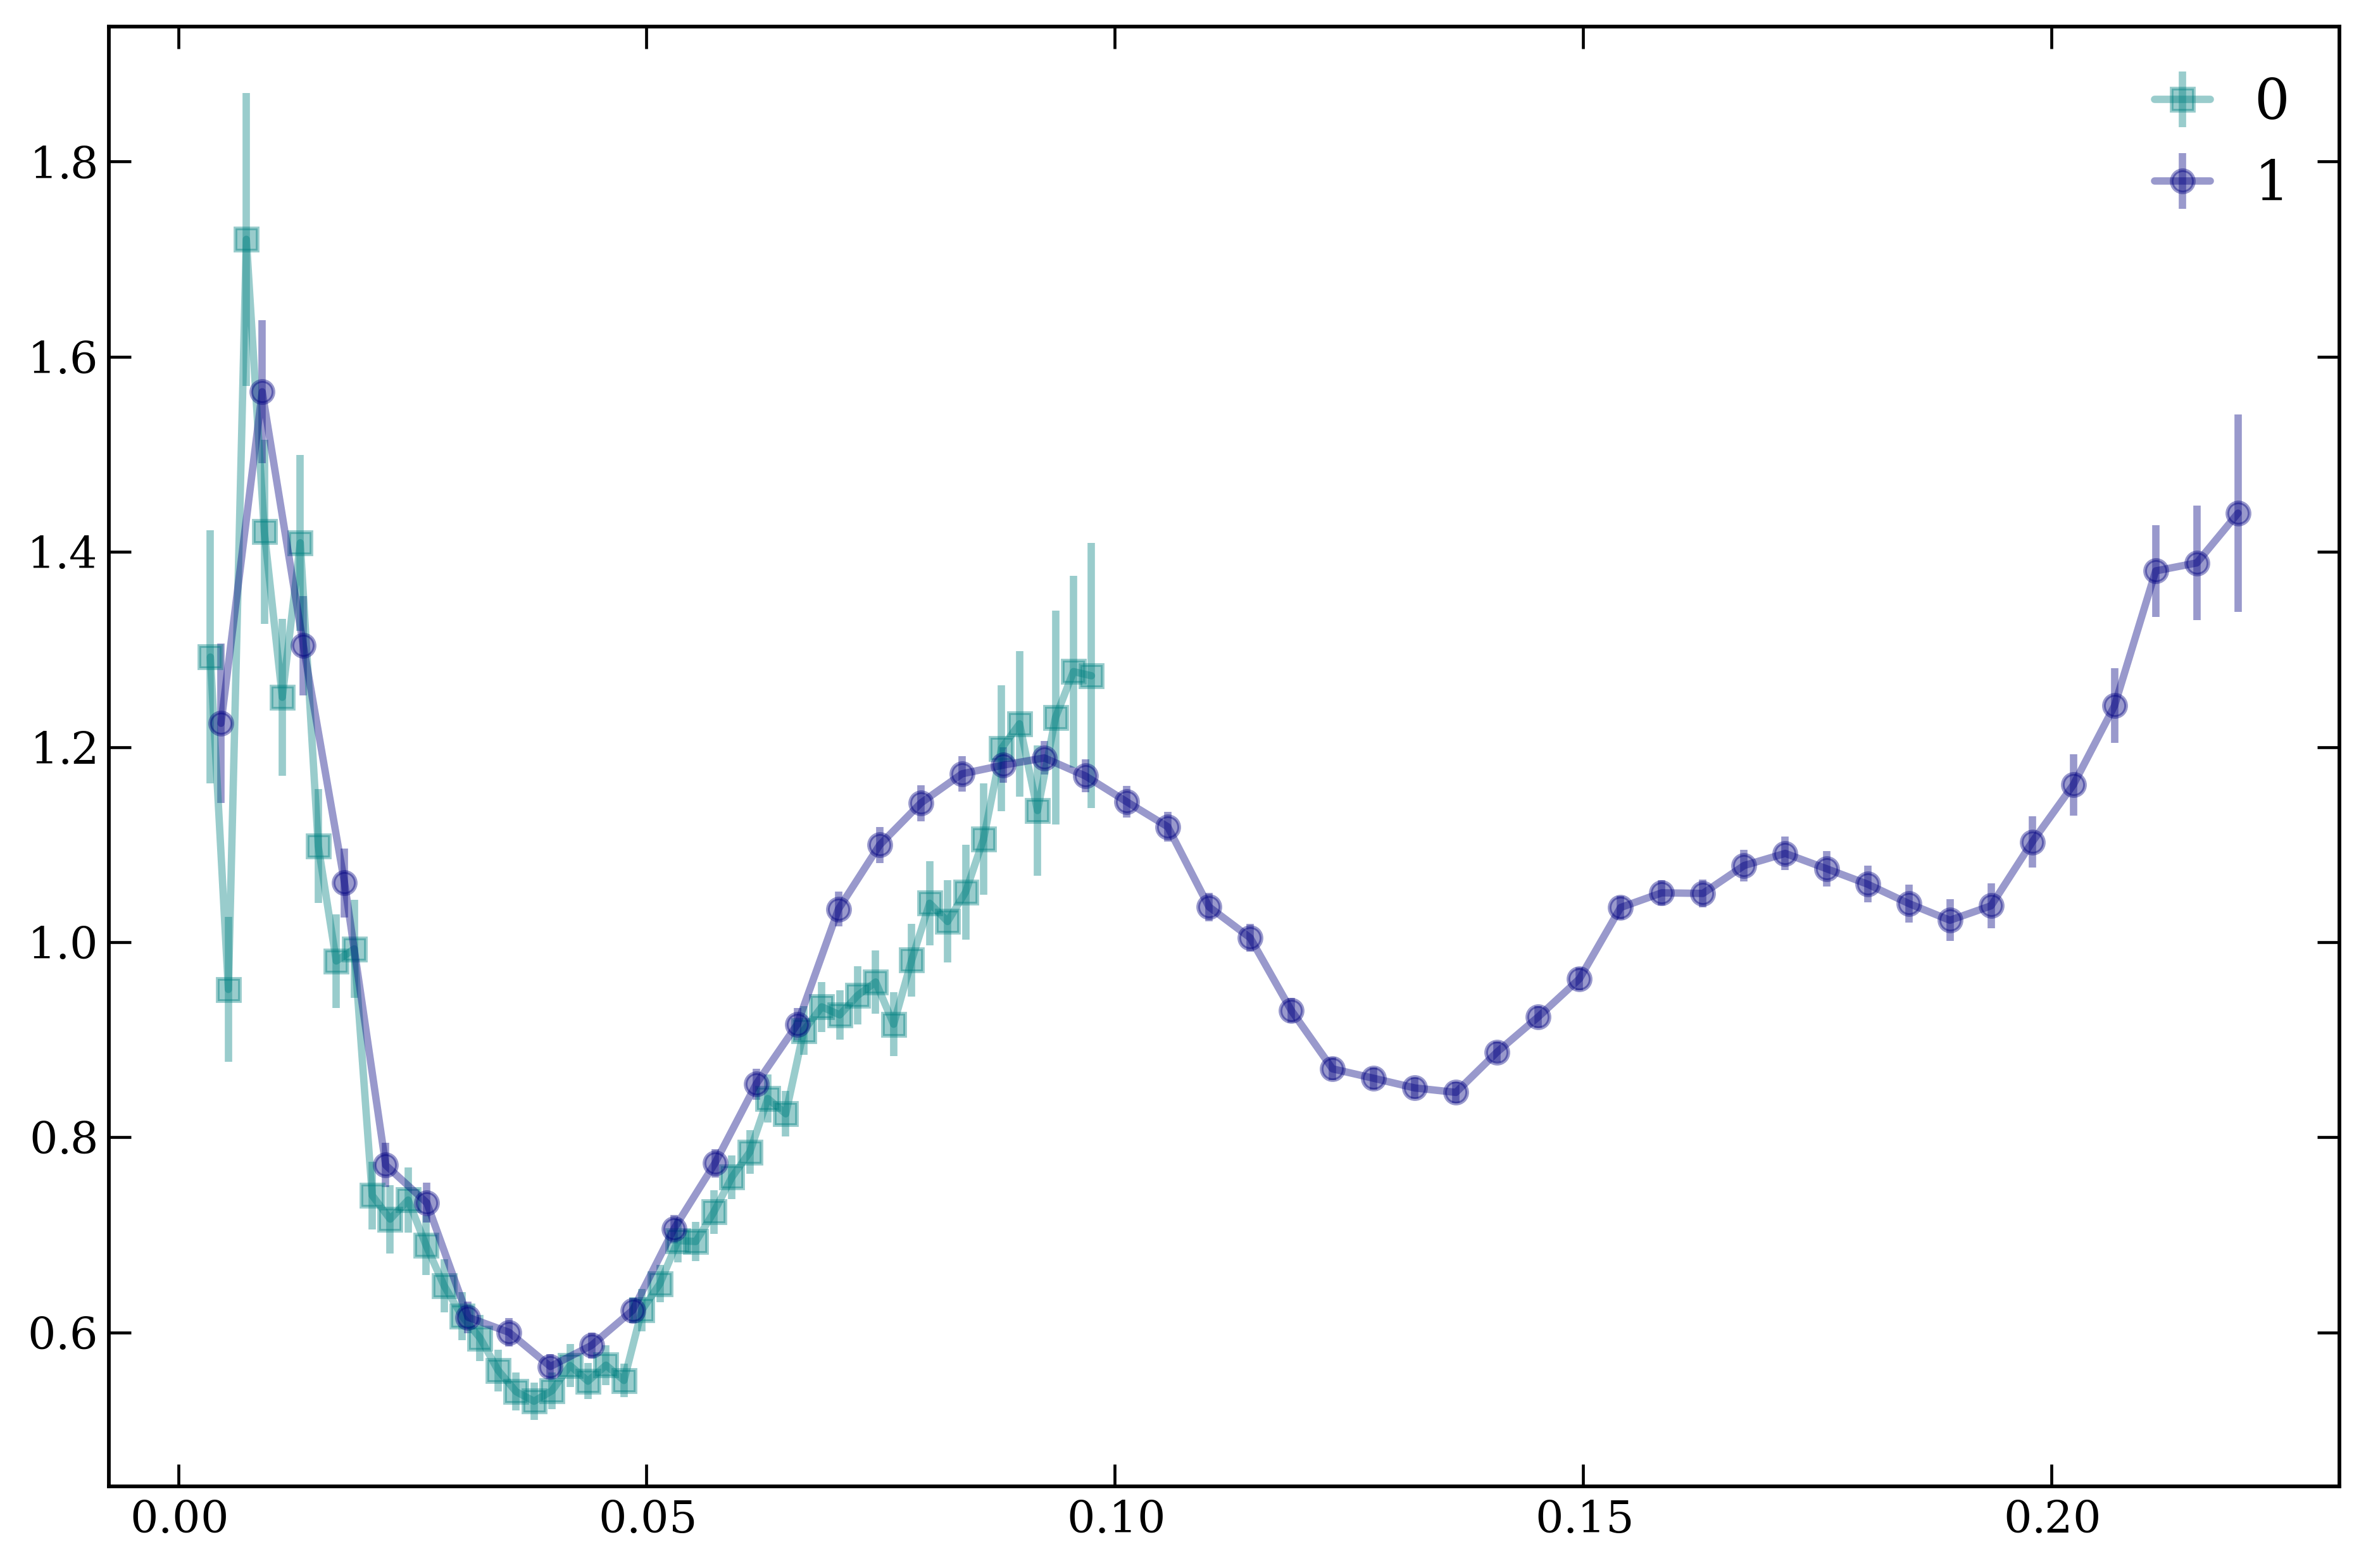

In [182]:
fig, ax = plt.subplots()
marker_list=['s','o','d']
for i, (kb, sf) in enumerate(zip([kbins1, kbins2],[sfac1, sfac2])):
    ax.errorbar(kb, np.nanmean(sf[:,:,0], axis=0), 
                 np.nanmean(sf[:,:,1], axis=0)/np.sqrt(5), 
                alpha=.4, label = f'{i}', marker=marker_list[i])
ax.legend()

In [ ]:
fig, ax = plt.subplots()
marker_list=['s','o','d']
for i, (kb, sf) in enumerate(zip([kbins0, kbins1, kbins2],[sfac0, sfac1, sfac2])):

    ax.errorbar(kb, np.nanmean(sf[:,:,0], axis=0), 
                 np.nanmean(sf[:,:,1], axis=0)/np.sqrt(10), 
                alpha=.4, label = f'{i}', marker=marker_list[i])
ax.legend()

# Cell 6 (revised): Overlay defects on the nematic director field

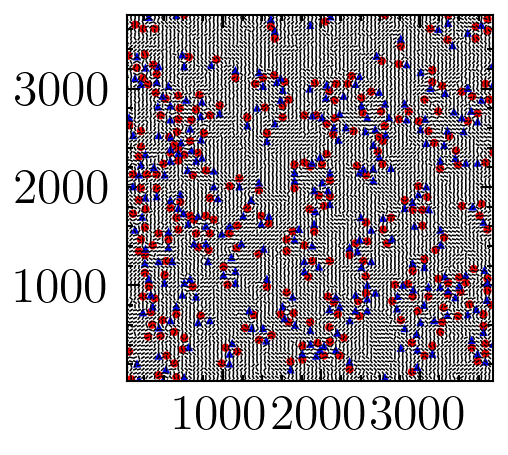

In [36]:
from matplotlib.collections import LineCollection
import scienceplots
plt.style.use('science')

k = t_map[10]

# Recompute the nematic director segments for frame k
U_s, V_s = U[:,:,k], V[:,:,k]
phi = 0.5 * np.arctan2(2*U_s*V_s, U_s**2 - V_s**2)  # angle in [0, π)
L = min(x_coords[1]-x_coords[0], y_coords[1]-y_coords[0]) * 2
Phi = phi.T
dxs =  L * 0.1 * np.cos(Phi)
dys =  L * 0.1 * np.sin(Phi)

segments = [
    [[x0 - dx, y0 - dy], [x0 + dx, y0 + dy]]
    for x0, y0, dx, dy in zip(Xg.ravel(), Yg.ravel(), dxs.ravel(), dys.ravel())
]

lc = LineCollection(segments, colors='black', linewidths=1)

# Plot
mm = 1/25.4

fig, ax = plt.subplots(figsize=(48*mm, 48*mm), dpi=300)
ax.add_collection(lc)

# Plot +1/2 defects: red filled circles
if plus_defects[k].size:
    ax.scatter(
        plus_defects[k][:,0], plus_defects[k][:,1],
        c='red', marker='o', s=4, label='+½', edgecolors='none'
    )

# Plot -1/2 defects: blue filled triangles
if minus_defects[k].size:
    ax.scatter(
        minus_defects[k][:,0], minus_defects[k][:,1],
        c='blue', marker='^', s=4, label='−½', edgecolors='none'
    )

ax.set_xlim(x_coords.min(), x_coords.max())
ax.set_ylim(y_coords.min(), y_coords.max()) 
ax.set_aspect('equal')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.legend(loc='upper right')
plt.show()

# Cell 7: ⟨Structure factor S(k)⟩ over all frames → divergence test

In [122]:
# 1) Precompute the k‐grid
Lx, Ly    = np.ptp(x_coords), np.ptp(y_coords)
dx, dy    = x_coords[1] - x_coords[0], y_coords[1] - y_coords[0]
dk        = 2 * np.pi / max(Lx, Ly)
kx        = np.arange(-np.pi/dx, np.pi/dx, dk)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = False

# 1) Precompute the k‐grid
Lx, Ly    = np.ptp(x_coords), np.ptp(y_coords)
dx, dy    = x_coords[1] - x_coords[0], y_coords[1] - y_coords[0]
dk        = 2 * np.pi / max(Lx, Ly)
kx        = np.arange(-np.pi/dx, np.pi/dx, dk)
ky        = np.arange(-np.pi/dy, np.pi/dy, dk)
KX, KY    = np.meshgrid(kx, ky)
Nkx, Nky  = KX.shape

# 2) Define radial bins
nbins     = 50
kr        = np.hypot(KX, KY).ravel()
bins      = np.linspace(0, kr.max(), nbins+1)
centers   = 0.5 * (bins[:-1] + bins[1:])

# 3) Accumulate S2d for each frame
S_accum = np.zeros((nt, Nkx, Nky))
for idx in range(nt):
  # pts = np.vstack([plus_defects[idx], minus_defects[idx]])
    ndef = len(defect_list[idx])
    #pts *= 40
    pts = np.random.uniform(x_coords.min(), x_coords.max(), size=(ndef,2))
    N   = len(pts)
    S2d = np.zeros_like(KX)
    if N > 0:
        for i in range(Nkx):
            for j in range(Nky):
                kv        = np.array([KX[i,j], KY[i,j]])
                S2d[i,j] = np.abs(np.sum(np.exp(-1j * (pts @ kv))))**2 / N
    S_accum[idx] = S2d

# 4) Radially average each frame → S_frame[idx, m]
S_frame = np.zeros((nt, nbins))
for idx in range(nt):
    flat = S_accum[idx].ravel()
    for m in range(nbins):
        mask = (kr >= bins[m]) & (kr < bins[m+1])
        if np.any(mask):
            S_frame[idx, m] = flat[mask].mean()

# 5) Compute mean and std over frames
S_k     = S_frame.mean(axis=0)
S_std   = S_frame.std(axis=0)

# 6) Choose low‐k fitting window (first 10% of nonzero k’s)
kvals    = centers
nonzero  = kvals > 0
fraction = 0.1
mask_k   = nonzero & (kvals < np.percentile(kvals[nonzero], fraction*100))

# 7) Fit γ in ⟨S(k)⟩ ∝ k^γ
gamma, intercept = np.polyfit(np.log(kvals[mask_k]), np.log(S_k[mask_k]), 1)

# 8) Plot with error bars and fit
mm = 1/25.4
fig, ax = plt.subplots(figsize=(48*mm, 48*mm), dpi=300)
# Error bars
ax.errorbar(
    centers, S_k, yerr=S_std, fmt='o', capsize=3, color='blue'
    , label=r'$\langle S(k) \rangle \pm \sigma$'
)
# Fit line
ax.plot(
    kvals[mask_k],
    np.exp(intercept) * kvals[mask_k] ** gamma,
    'r--',
    label=fr'Fit: $k^{{{gamma:.2f}}}$'
)
# Log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and legend
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\langle S(k) \rangle$')
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(data_dirs,'sfac_possion.png'), dpi=420,)

# Cell 8: ⟨Number‐variance σ²(R)⟩ over all frames → growth exponent α

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('sg_article')
plt.rcParams['text.usetex'] = False

Lx, Ly    = np.ptp(x_coords), np.ptp(y_coords)
dx, dy    = x_coords[1] - x_coords[0], y_coords[1] - y_coords[0]
xmin, xmax = x_coords.min(), x_coords.max()
ymin, ymax = y_coords.min(), y_coords.max()

def number_variance(pts, R, n_samples=5):
    counts = []
    xmin, xmax = x_coords.min(), x_coords.max()
    ymin, ymax = y_coords.min(), y_coords.max()
    for _ in range(n_samples):
        x0 = random.uniform(xmin, xmax)
        y0 = random.uniform(ymin, ymax)
        counts.append(((pts[:,0]-x0)**2 + (pts[:,1]-y0)**2 < R**2).sum())
    #print(R, ((pts[:,0]-x0)**2 + (pts[:,1]-y0)**2 < R**2).sum(), np.mean(counts))
    if R > 900: print(R,counts)
    return np.var(counts), np.mean(counts)

# 1) Define R values and accumulate variances
Rs         = np.linspace(40, min(Lx, Ly)/4, 40)
vars_accum = np.zeros((nt, len(Rs)))

for idx in range(2):
    #pts = np.vstack([plus_defects[idx], minus_defects[idx]])
    ndef = len(defect_list[idx])
    #pts *= 40
    pts = np.random.uniform(xmin, xmax, size=(ndef,2))
    for i, R in enumerate(Rs):
        v, _ = number_variance(pts, R, n_samples=200)
        vars_accum[idx, i] = v

# 2) Compute mean and std over frames
vars_mean = vars_accum.mean(axis=0)
vars_std  = vars_accum.std(axis=0)

# 3) Fit α in ⟨σ²(R)⟩ ∝ R^α
ridx_min = 20
alpha, intercept = np.polyfit(np.log(Rs[ridx_min:]), np.log(vars_mean[ridx_min:]), 1)

# 4) Plot with error bars and fit
mm = 1/25.4
#fig, ax = plt.subplots(figsize=(54*mm, 48*mm), dpi=300)
fig, ax = plt.subplots(figsize=(9,6), dpi=300)
# Error bars
ax.errorbar(Rs, vars_mean, yerr=vars_std, fmt='o', capsize=3, color='blue',
            label=r'$\langle\sigma^2(R)\rangle \pm \sigma$', alpha=.5, zorder=-10)
# Fit line

ax.plot(
    Rs[ridx_min:],
    np.exp(intercept) * Rs[ridx_min:]**alpha,
    'r--',
    label=fr'Fit: $R^{{\alpha}}$ (α={alpha:.2f})'
)
# Log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and legend
#ax.set_xlabel('R')
#ax.set_ylabel(r'$\langle\sigma^2(R)\rangle$')
ax.legend(loc='lower right')
fig.tight_layout()


In [78]:
# 1) Precompute the k‐grid
Lx, Ly    = np.ptp(x_coords), np.ptp(y_coords)
dx, dy    = x_coords[1] - x_coords[0], y_coords[1] - y_coords[0]
dk        = 2 * np.pi / max(Lx, Ly)
kx        = np.arange(-np.pi/dx, np.pi/dx, dk)
ky        = np.arange(-np.pi/dy, np.pi/dy, dk)
KX, KY    = np.meshgrid(kx, ky)
Nkx, Nky  = KX.shape

In [119]:
x_shift = [0, x_coords[1] - x_coords[0]]
LX = x_coords.max() - x_coords.min() - 40
LX_shift = (LX - LX/2)

kvals = 2*np.pi / (np.arange(1, (x_coords.max() - x_coords.min()) / 2, dx))

kvals_shift = 2*np.pi / (np.arange(-LX_shift/2,LX_shift/2+1, dx))

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4320\3948992990.py:7: RuntimeWarning: divide by zero encountered in divide
  kvals_shift = 2*np.pi / (np.arange(-LX_shift/2,LX_shift/2+1, dx))


In [ ]:
# 1) Precompute the k‐grid
Lx, Ly    = np.ptp(x_coords), np.ptp(y_coords)
dx, dy    = x_coords[1] - x_coords[0], y_coords[1] - y_coords[0]
dk        = 2 * np.pi / max(Lx, Ly)
kx        = np.arange(-np.pi/dx, np.pi/dx, dk)
ky        = np.arange(-np.pi/dy, np.pi/dy, dk)
KX, KY    = np.meshgrid(kx, ky)
Nkx, Nky  = KX.shape

# 2) Define radial bins
nbins     = 50
kr        = np.hypot(KX, KY).ravel()
bins      = np.linspace(0, kr.max(), nbins+1)
centers   = 0.5 * (bins[:-1] + bins[1:])
centers

# autocorrelation

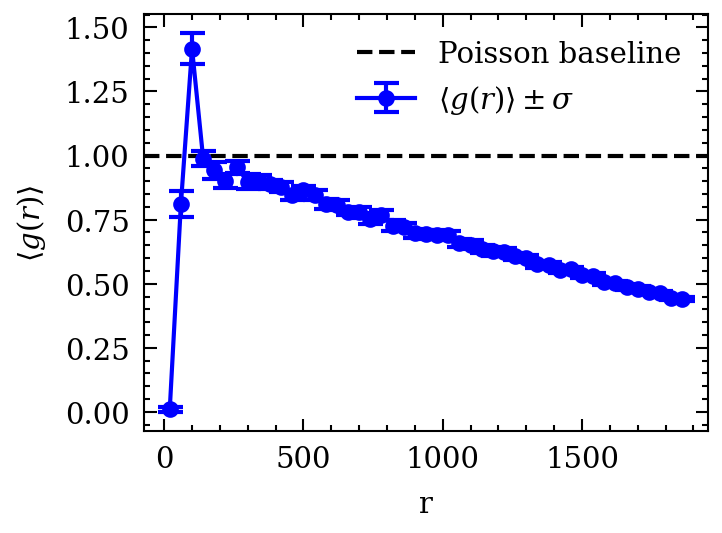

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

def radial_pair_correlation(pts, r_max, dr, area):
    """
    Compute g(r) for a set of points `pts` in a periodic box of given `area`.
    
    Parameters
    ----------
    pts : (N,2) array
      Defect positions.
    r_max : float
      Maximum radius to compute g(r).
    dr : float
      Bin width.
    area : float
      Total area of the domain.
    
    Returns
    -------
    r : (M,) array
      Bin centers.
    g : (M,) array
      Pair correlation g(r).
    """
    N = len(pts)
    if N < 2:
        # no pairs → zero everywhere
        bins = np.arange(0, r_max+dr, dr)
        r = 0.5*(bins[:-1] + bins[1:])
        return r, np.zeros_like(r)
    
    # all pairwise distances
    dists = pdist(pts)  # shape (N*(N-1)/2,)
    
    # histogram
    bins = np.arange(0, r_max+dr, dr)
    hist, _ = np.histogram(dists, bins=bins)
    r = 0.5*(bins[:-1] + bins[1:])
    
    # normalization factor for an ideal Poisson:
    # expected number of pairs in [r, r+dr]: 
    #   N * density * (2πr dr)
    density = N / area
    norm = N * density * 2 * np.pi * r * dr
    
    # convert histogram of pairs → g(r)
    # note: pdist counts each pair once, ideal gas counts each *ordered* pair,
    # so we divide norm by 2 to match unordered pairs:
    g = hist / (norm / 2)
    
    return r, g

# parameters
Lx, Ly = np.ptp(x_coords), np.ptp(y_coords)
area    = Lx * Ly
r_max   = min(Lx, Ly) / 2
dr      = min(x_coords[1]-x_coords[0], y_coords[1]-y_coords[0])  # one grid spacing

# collect g(r) from each frame
all_g = []
all_r = None

for idx in range(nt):
    pts = np.vstack([plus_defects[idx], minus_defects[idx]])  # (Ni,2)
    r, g = radial_pair_correlation(pts, r_max, dr, area)
    all_g.append(g)
    if all_r is None:
        all_r = r

all_g = np.vstack(all_g)
g_mean = all_g.mean(axis=0)
g_std  = all_g.std(axis=0)

# --- Create figure and axis ---
mm = 1/25.4
fig, ax = plt.subplots(figsize=(64*mm, 48*mm), dpi=300)
# --- Plot g(r) with error bars ---
ax.errorbar(all_r, g_mean, yerr=g_std, fmt='o-', capsize=3, color='blue',
            label=r'$\langle g(r) \rangle \pm \sigma$')

# --- Add Poisson baseline ---
ax.axhline(1, color='k', linestyle='--', label='Poisson baseline')

# --- Labeling ---
ax.set_xlabel('r')
ax.set_ylabel(r'$\langle g(r) \rangle$')
ax.legend()

# --- Layout and show ---
fig.tight_layout()
plt.show()